# Why can the instantaneous frequency of a band-pass filtered chirp recording go down ...
... if a chirp is an up-modulation of the frequency? 

This is the question we try to answer in this notebook

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import thunderfish.fakefish as ff 
from filters import instantaneous_frequency, bandpass_filter
from plotstyle import PlotStyle

# %matplotlib qt
ps = PlotStyle()

# parameters that stay the same
samplerate = 20000
duration = 0.2
chirp_freq = 5
smooth = 3

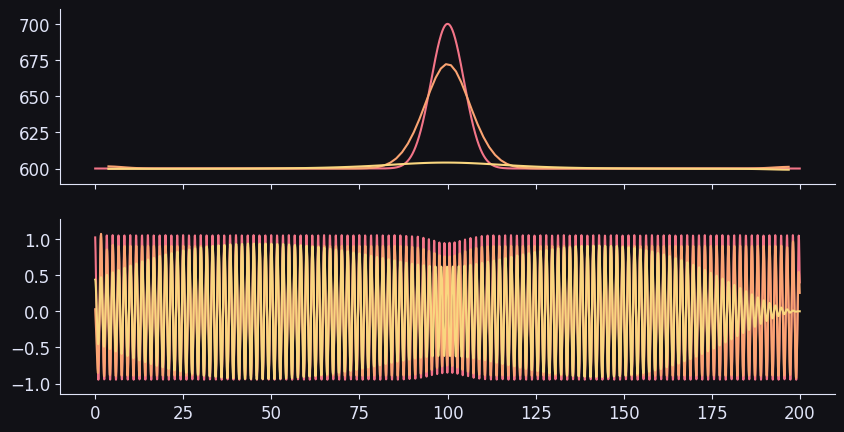

In [23]:
def make_chirp(eodf, size, width, kurtosis, contrast, phase0):

    chirp_trace, amp = ff.chirps(
        eodf = eodf,
        samplerate = samplerate,
        duration = duration,
        chirp_freq = chirp_freq,
        chirp_size = size,
        chirp_width = width,
        chirp_kurtosis = kurtosis,
        chirp_contrast = contrast,
    )

    chirp = ff.wavefish_eods(
        fish = 'Alepto',
        frequency = chirp_trace,
        samplerate = samplerate,
        duration = duration,
        phase0 = phase0,
        noise_std = 0,
    )

    chirp *= amp

    return chirp_trace, chirp

def filtered_chirp(eodf, size, width, kurtosis, contrast, phase0):

    time = np.arange(0, duration, 1/samplerate)
    chirp_trace, chirp = make_chirp(
        eodf = eodf, 
        size = size, 
        width = width, 
        kurtosis = kurtosis, 
        contrast = contrast, 
        phase0 = phase0,
    )

    # apply filters
    narrow_filtered = bandpass_filter(chirp, samplerate, eodf-10, eodf+10)
    narrow_freqtime, narrow_freq = instantaneous_frequency(narrow_filtered, samplerate, smooth)
    broad_filtered = bandpass_filter(chirp, samplerate, eodf-300, eodf+300)
    broad_freqtime, broad_freq = instantaneous_frequency(broad_filtered, samplerate, smooth)

    original = (time, chirp_trace, chirp)
    broad = (broad_freqtime, broad_freq, broad_filtered)
    narrow = (narrow_freqtime, narrow_freq, narrow_filtered)

    return original, broad, narrow

def plot(original, broad, narrow, axs):

    axs[0].plot(original[0]*1000, original[1], label='chirp trace', color=ps.gblue1)
    axs[0].plot(broad[0]*1000, broad[1], label='broad filtered', color=ps.gblue2)
    axs[0].plot(narrow[0]*1000, narrow[1], label='narrow filtered', color=ps.gblue3)
    axs[1].plot(original[0]*1000, original[2], label='unfiltered', color=ps.gblue1)
    axs[1].plot(original[0]*1000, broad[2], label='broad filtered', color=ps.gblue2)
    axs[1].plot(original[0]*1000, narrow[2], label='narrow filtered', color=ps.gblue3)

original, broad, narrow = filtered_chirp(600, 100, 0.02, 1, 0.1, 0)
fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
plot(original, broad, narrow, axs)
fig.align_labels()
plt.show()

## Chirp size
now that we have established an easy way to simulate and plot the chirps, lets change the chirp size and see how the narrow-filtered instantaneous frequency changes.

size 10 Hz; Integral 0.1168
size 20 Hz; Integral 0.2336
size 30 Hz; Integral 0.3504
size 40 Hz; Integral 0.4672
size 50 Hz; Integral 0.584
size 60 Hz; Integral 0.7008
size 70 Hz; Integral 0.8176
size 80 Hz; Integral 0.9345
size 90 Hz; Integral 1.0513
size 100 Hz; Integral 1.1681
size 110 Hz; Integral 1.2849
size 120 Hz; Integral 1.4017
size 130 Hz; Integral 1.5185
size 140 Hz; Integral 1.6353
size 150 Hz; Integral 1.7521


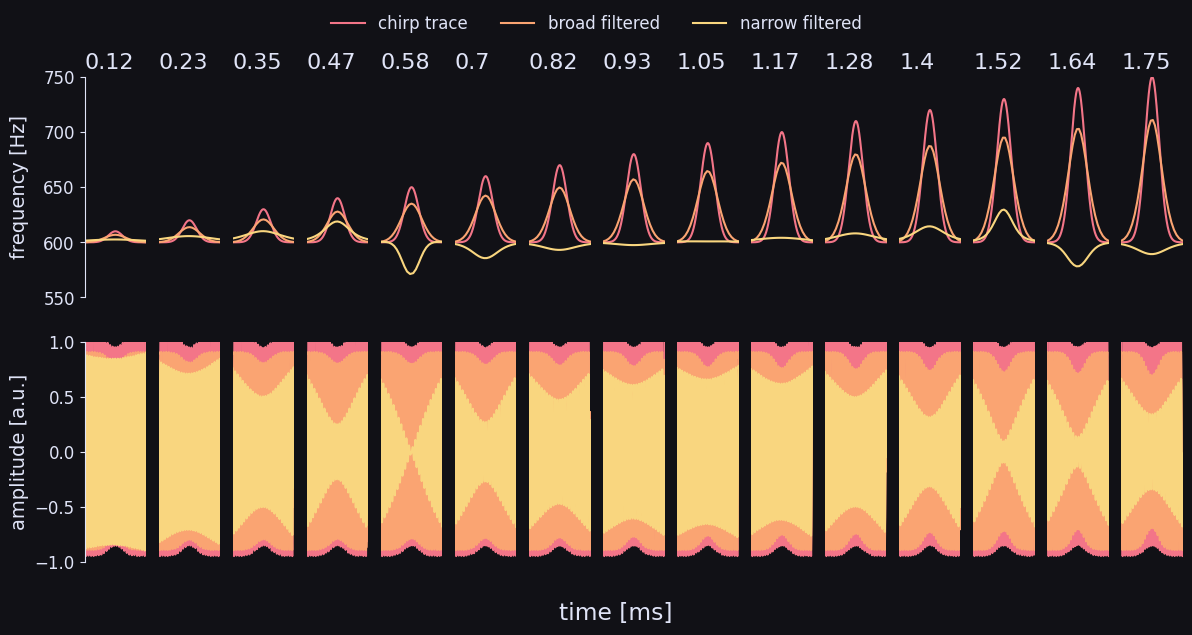

In [41]:
sizes = np.arange(10, 160, 10)
fig, axs = plt.subplots(2, len(sizes), figsize=(36*ps.cm, 16*ps.cm))
integrals = []

for i, size in enumerate(sizes):
    original, broad, narrow = filtered_chirp(600, size, 0.02, 1, 0.1, 0)

    integral = np.sum(original[1] - 600)/(20000)
    integrals.append(integral)

    plot(original, broad, narrow, axs[:, i])

    axs[:, i][0].set_xlim(0.08*1000, 0.12*1000)
    axs[:, i][0].set_ylim(550, 750)
    axs[:, i][1].set_xlim(0.08*1000, 0.12*1000)
    axs[:, i][1].set_ylim(-1, 1)

    axs[0, i].set_title(np.round(integral, 2))
    print(f'size {size} Hz; Integral {np.round(integral, 4)}')

    # hide all x axes
    for ax in axs[:, i]:
        ax.set_xlabel('')
        ax.set_xticks([])
        ax.spines['bottom'].set_visible(False)

    # remove all but the firt y axis
    if i != 0:
        for ax in axs[:, i]:
            ax.set_ylabel('')
            ax.set_yticks([])
            ax.spines['left'].set_visible(False)


fig.legend(handles=axs[0,0].get_lines(), loc='upper center', ncol=3)
axs[0,0].set_ylabel('frequency [Hz]')
axs[1,0].set_ylabel('amplitude [a.u.]')
fig.supxlabel('time [ms]')
fig.align_labels()
plt.savefig('../assets/width.svg')
plt.show()

## Chirp width

In [ ]:
widths = np.arange(0.02, 0.08, 0.005)
fig, axs = plt.subplots(2, len(widths), figsize=(10, 5), sharex=True, sharey='row')
integrals = []

for i, width in enumerate(widths):
    if i > 9:
        break

    original, broad, narrow = filtered_chirp(600, 100, width, 1, 0.1, 0)

    integral = np.sum(original[1]-600)/(20000)

    plot(original, broad, narrow, axs[:, i])
    axs[:, i][0].set_xlim(0.06, 0.14)
    axs[0, i].set_title(f'width {np.round(width, 2)} s')
    print(f'width {width} s; Integral {np.round(integral, 3)}')
 
fig.legend(handles=axs[0,0].get_lines(), loc='upper center', ncol=3)
axs[0,0].set_ylabel('frequency [Hz]')
axs[1,0].set_ylabel('amplitude [a.u.]')
fig.supxlabel('time [s]')
fig.align_labels()
plt.show()

## Chirp kurtosis

In [ ]:
kurtosiss = np.arange(0, 20, 1.6)
fig, axs = plt.subplots(2, len(kurtosiss), figsize=(10, 5), sharex=True, sharey='row')
integrals = []

for i, kurtosis in enumerate(kurtosiss):

    original, broad, narrow = filtered_chirp(600, 100, 0.02, kurtosis, 0.1, 0)

    integral = np.sum(original[1]-600)/(20000)

    plot(original, broad, narrow, axs[:, i])
    axs[:, i][0].set_xlim(0.06, 0.14)
    axs[0, i].set_title(f'kurt {np.round(kurtosis, 2)}')
    print(f'kurt {kurtosis}; Integral {np.round(integral, 3)}')
 
fig.legend(handles=axs[0,0].get_lines(), loc='upper center', ncol=3)
axs[0,0].set_ylabel('frequency [Hz]')
axs[1,0].set_ylabel('amplitude [a.u.]')
fig.supxlabel('time [s]')
fig.align_labels()
plt.show()

## Chirp contrast

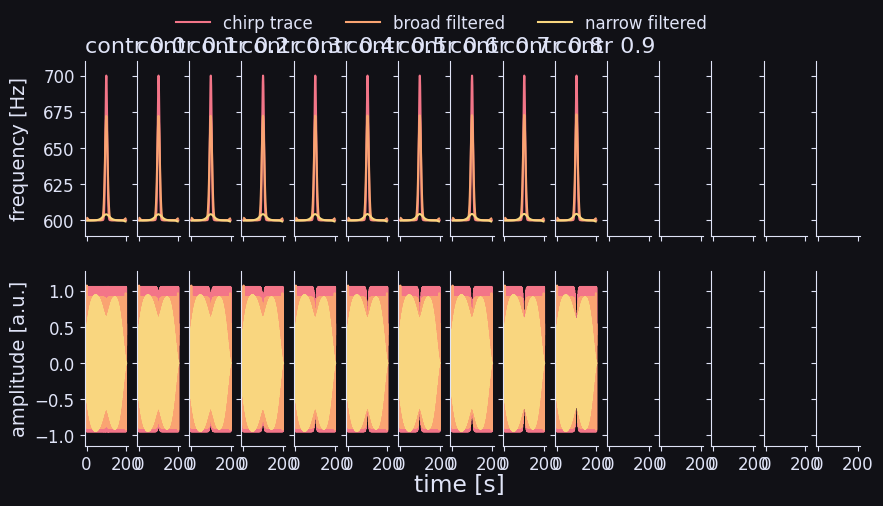

In [37]:
contrasts = np.arange(0.0, 1.1, 0.1)
fig, axs = plt.subplots(2, len(sizes), figsize=(10, 5), sharex=True, sharey='row')
integrals = []

for i, contrast in enumerate(contrasts):
    if i > 9:
        break
    original, broad, narrow = filtered_chirp(600, 100, 0.02, 1, contrast, 0)

    integral = np.trapz(original[2], original[0])
    integrals.append(integral)

    plot(original, broad, narrow, axs[:, i])
    # axs[:, i][0].set_xlim(0.06, 0.14)
    axs[0, i].set_title(f'contr {np.round(contrast, 2)}')
 
fig.legend(handles=axs[0,0].get_lines(), loc='upper center', ncol=3)
axs[0,0].set_ylabel('frequency [Hz]')
axs[1,0].set_ylabel('amplitude [a.u.]')
fig.supxlabel('time [s]')
fig.align_labels()
plt.show()

## Chirp phase 

In [ ]:
phases = np.arange(0.0, 2 * np.pi, 0.2)
fig, axs = plt.subplots(2, len(sizes), figsize=(10, 5), sharex=True, sharey='row')
integrals = []
for i, phase in enumerate(phases):
    if i > 9:
        break

    original, broad, narrow = filtered_chirp(600, 100, 0.02, 1, 0.1, phase)

    integral = np.trapz(original[2], original[0])
    integrals.append(integral)

    plot(original, broad, narrow, axs[:, i])
    # axs[:, i][0].set_xlim(0.06, 0.14)
    axs[0, i].set_title(f'phase {np.round(phase, 2)}')

 
fig.legend(handles=axs[0,0].get_lines(), loc='upper center', ncol=3)
axs[0,0].set_ylabel('frequency [Hz]')
axs[1,0].set_ylabel('amplitude [a.u.]')
fig.supxlabel('time [s]')
fig.align_labels()
plt.show()

These experiments show, that the narrow filtered instantaneous freuqency only switches its sign, when the integral of the instantaneous frequency (that was used to make the signal)
changes. Specifically, when the instantaneous frequency is 0.57, 1.57, 2.57 etc., the sign swithes. 